## EDA template

In [193]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
raw_df = pd.read_csv('data/Train.zip')

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 1. Data Analysis
#### Meta data
* How many samples and features?
* What features are numeric vs. categorical

#### Data
* Inconsistent value types
* Missing values
* Zero values
* Incorrect values: sold before manufactured

In [195]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

In [196]:
pp.ProfileReport(raw_df)

In [197]:
# pd.plotting.scatter_matrix(raw_df)
# better use seaborn pairplot, see next cell

In [198]:
# sns.pairplot(raw_df)

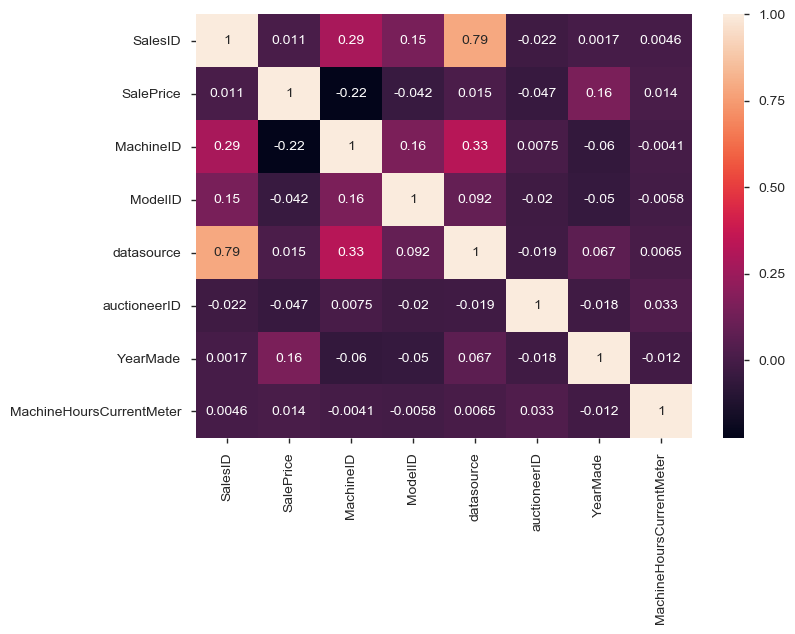

In [199]:
# Useful to get actual correlation numbers
sns.heatmap(raw_df.corr(), annot=True)

In [200]:
# plt.scatter(raw_df['YearMade'], dt.date2num(pd.to_datetime(raw_df['saledate'])))

# 2. Data Cleaning and Preparation
## 2.1 Dates to numerical

In [201]:
# getting correlations with dates by using date2num
import matplotlib.dates as dt
dt.num2date(300)

datetime.datetime(1, 10, 27, 0, 0, tzinfo=datetime.timezone.utc)

In [202]:
pd.to_datetime(raw_df['saledate'][3])

Timestamp('2011-05-19 00:00:00')

In [203]:

dt.date2num(pd.to_datetime(raw_df['saledate'][3]))
#type(raw_df['saledate'][3])

734276.0

In [204]:
dateNum = dt.date2num(pd.to_datetime(raw_df['saledate']))
type(dateNum)

numpy.ndarray

## 2.2 Fill missing values

* replace the implausible values of YearMade by using KNN:

In [205]:
from sklearn.neighbors import KNeighborsRegressor

In [208]:
X_all = raw_df[['ModelID','YearMade']] #produces a DataFrame! type(X)
X_all.loc[:,'saledate_num'] = pd.Series(dateNum)
X_all.head()

ModelID  YearMade  saledate_num
0     3157      2004      732631.0
1       77      1996      731666.0
2     7009      2001      731637.0
3      332      2001      734276.0
4    17311      2007      733611.0

In [209]:
X_train = X_all[X_all['YearMade']>1000]
y = X_train['YearMade']
X_train.drop('YearMade',axis=1,inplace=True)
X_train.head()

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


ModelID  saledate_num
0     3157      732631.0
1       77      731666.0
2     7009      731637.0
3      332      734276.0
4    17311      733611.0

In [210]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y) 

neigh.predict(X_train)

array([2004. , 1995. , 2000.5, ..., 2005. , 2005. , 2005. ])

In [211]:
X_to_fill = X_all[X_all['YearMade'] <= 1000]
X_to_fill.drop('YearMade',axis=1,inplace=True)

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [212]:
year_predicted = neigh.predict(X_to_fill)

In [213]:
len(X_to_fill)

38185

In [225]:
year_predicted

array([1989.5, 1987. , 1997. , ..., 2005. , 2005. , 2004. ])

In [215]:
# X_all['YearMade'][X_all['YearMade'] <= 1000] = year_predicted # works, too (with more warnings)
X_all.loc[X_all['YearMade'] <= 1000, 'YearMade'] = pd.DataFrame(year_predicted)

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [216]:
X_all.head()

ModelID  YearMade  saledate_num
0     3157    2004.0      732631.0
1       77    1996.0      731666.0
2     7009    2001.0      731637.0
3      332    2001.0      734276.0
4    17311    2007.0      733611.0

In [217]:
X_all.loc[X_all['YearMade'] <= 1000].head()

Empty DataFrame
Columns: [ModelID, YearMade, saledate_num]
Index: []

- we replaced all the implausible YearMade values with plausible ones. No '1000's anymore. 

# 3 Linear Regression

In [218]:
import statsmodels.api as sm

In [219]:
raw_df['ModelID'].head()

0     3157
1       77
2     7009
3      332
4    17311
Name: ModelID, dtype: int64

In [220]:
X_all['ModelID'].head()

0     3157
1       77
2     7009
3      332
4    17311
Name: ModelID, dtype: int64

In [221]:
X = X_all
y = raw_df['SalePrice']

In [223]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 3 columns):
ModelID         401125 non-null int64
YearMade        362940 non-null float64
saledate_num    401125 non-null float64
dtypes: float64(2), int64(1)
memory usage: 9.2 MB


In [222]:
model = sm.OLS(y, X)
results = model.fit()
results.summary()


MissingDataError: exog contains inf or nans

In [158]:
X.head()

ModelID  YearMade  saledate_num
0     3157    2004.0      732631.0
1       77    1996.0      731666.0
2     7009    2001.0      731637.0
3      332    2001.0      734276.0
4    17311    2007.0      733611.0

In [159]:
results.predict(X).head()

0    38414.739296
1    35265.294920
2    36929.218541
3    33700.017355
4    34232.568506
dtype: float64

## Test Score

In [163]:
X_test = pd.read_csv('data/Test.zip')

In [164]:
df_sol = pd.read_csv("data/do_not_open/test_soln.csv.zip")

dateNum = dt.date2num(pd.to_datetime(X_test['saledate']))
X_test['saledate_num'] = pd.Series(dateNum)
X_test.head()

SalesID  MachineID  ModelID  datasource  auctioneerID  YearMade  \
0  1222837     902859     1376         121             3      1000   
1  1222839    1048320    36526         121             3      2006   
2  1222841     999308     4587         121             3      2000   
3  1222843    1062425     1954         121             3      1000   
4  1222845    1032841     4701         121             3      2002   

   MachineHoursCurrentMeter UsageBand       saledate fiModelDesc  ...  \
0                       0.0       NaN  1/5/2012 0:00        375L  ...   
1                    4412.0    Medium  1/5/2012 0:00    TX300LC2  ...   
2                   10127.0    Medium  1/5/2012 0:00       270LC  ...   
3                    4682.0       Low  1/5/2012 0:00      892DLC  ...   
4                    8150.0    Medium  1/4/2012 0:00        544H  ...   

          Stick_Length                Thumb      Pattern_Changer Grouser_Type  \
0  None or Unspecified  None or Unspecified  None or Unspecified       Double   
1               12' 4"  None or Unspecified                  Yes       Double   
2               12' 4"  None or Unspecified  None or Unspecified       Double   
3  None or Unspecified  None or Unspecified  None or Unspecified       Double   
4                  NaN                  NaN                  NaN          NaN   

  Backhoe_Mounting Blade_Type Travel_Controls Differential_Type  \
0              NaN        NaN             NaN               NaN   
1              NaN        NaN             NaN               NaN   
2              NaN        NaN             NaN               NaN   
3              NaN        NaN             NaN               NaN   
4              NaN        NaN             NaN          Standard   

  Steering_Controls saledate_num  
0               NaN     734507.0  
1               NaN     734507.0  
2               NaN     734507.0  
3               NaN     734507.0  
4      Conventional     734506.0  

[5 rows x 53 columns]

In [165]:
def score(self, predictions):
        log_diff = np.log(predictions+1) - np.log(self+1)
        return np.sqrt(np.mean(log_diff**2))

In [166]:
X_test = X_test[['ModelID','YearMade','saledate_num']]

In [167]:
# X_train = X_test[X_all['YearMade']>1000]
# y = X_train['YearMade']
# X_train.drop('YearMade',axis=1,inplace=True)
# X_train.head()

In [168]:
X_t_to_fill = X_test[X_test['YearMade'] <= 1500]
X_t_to_fill.drop('YearMade',axis=1,inplace=True)

year_predicted_t = neigh.predict(X_t_to_fill)
# X_test.loc[X_test['YearMade'] <= 1000, 'YearMade'] = pd.DataFrame(year_predicted_t)
X_test['YearMade'][X_test['YearMade'] <= 1000] = year_predicted_t

/Users/franzmornau/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [169]:
year_predicted_t

array([1999. , 1996. , 1991.5, ..., 2001. , 2000. , 2005. ])

In [170]:
X_test.head()

ModelID  YearMade  saledate_num
0     1376      1999      734507.0
1    36526      2006      734507.0
2     4587      2000      734507.0
3     1954      1996      734507.0
4     4701      2002      734506.0

In [172]:
test_prediction = model.predict(X_test)

ValueError: shapes (401125,3) and (11573,3) not aligned: 3 (dim 1) != 11573 (dim 0)

In [137]:
rmsle = score(df_sol["SalePrice"], test_prediction)
rmsle

ValueError: shapes (401125,3) and (11573,3) not aligned: 3 (dim 1) != 11573 (dim 0)

In [133]:
X.columns

Index(['ModelID', 'YearMade', 'saledate_num'], dtype='object')